#   Implementation of simple density estimation

Author:  Stephen Menary  (stmenary@cern.ch)

In [1]:
import numpy             as     np
import matplotlib.pyplot as     plt
import scipy.stats       as     stats
from   iminuit           import Minuit

In [209]:
def forward_pass (x, mean, width) :
    return mean + x * width

def reverse_pass (x, mean, width) :
    return (x - mean) * width

class OneDimensionalFlow :
    def __init__ (self, num_layers=1) :
        self.set_num_layers(num_layers)
    def fit (self, dataset) :
        def fit_func (params) :
            return self.sum_TNLL(dataset, params)
        m = Minuit.from_array_func (fit_func,
                                    self.params, 
                                    error    = np.ones(shape=self.params.shape),
                                    errordef = 1)
        m.migrad(precision=1e-6)
        print(m.get_param_states())
        self.params = np.array([j for i,j in m.values.items()])
    def forward_pass (self, dataset, params=None) :
        if type(params) == type(None) :
            params = self.params
        num_layers = self.num_layers
        layer_params = [(params[2*i], params[2*i+1]) for i in range(num_layers)]
        transformed_data = dataset
        for i in range(num_layers) :
            mean, width = layer_params [i]
            transformed_data = forward_pass(transformed_data, mean, width)
        return transformed_data
    def likelihood (self, dataset, params=None) :
        return stats.norm.pdf(self.reverse_pass(dataset, params))
    def TNLL (self, dataset, params=None) :
        return -2. * np.log(self.likelihood(dataset, params))
    def reverse_pass (self, dataset, params=None) :
        if type(params) == type(None) :
            params = self.params
        num_layers = self.num_layers
        layer_params = [(params[2*i], params[2*i+1]) for i in range(num_layers-1, -1, -1)]
        transformed_data = dataset
        for i in range(num_layers) :
            mean, width = layer_params [i]
            transformed_data = reverse_pass(transformed_data, mean, width)
        return transformed_data
    def set_num_layers (self, num_layers) :
        self.num_layers = num_layers
        self.params     = np.ones(shape=(2*num_layers,))
    def sum_likelihood (self, dataset, params=None) :
        return np.sum(self.likelihood(dataset, params))
    def sum_TNLL (self, dataset, params=None) :
        return np.sum(self.TNLL(dataset, params))
            

In [210]:
true_params = np.array([10., 2.])
dataset = np.random.normal(true_params[0], true_params[1], 10000)


In [216]:
def likelihood (x, mean, sigma) :
    return stats.norm.pdf(dataset, mean, sigma) / sigma

def TNLL (x, mean, sigma) :
    return -2. * np.sum(np.log(likelihood(x, mean, sigma)))

def fit_func (x, mean, sigma) :
    return -1. * np.mean(likelihood(x, mean, sigma))

model = OneDimensionalFlow(1)
model.params = true_params

print(TNLL(dataset, true_params[0]    , true_params[1]))
print(TNLL(dataset, true_params[0]+0.1, true_params[1]))
print(TNLL(dataset, true_params[0]    , true_params[1]+0.1))

print(model.sum_TNLL(dataset, [true_params[0]    , np.log(true_params[1])]))
print(model.sum_TNLL(dataset, [true_params[0]+0.1, np.log(true_params[1])]))
print(model.sum_TNLL(dataset, [true_params[0]    , np.log(true_params[1]+0.1)]))

56104.39519472148
56141.186149779125
57126.3209686701
28378.50797232367
28415.298927381325
27448.827179495012


In [214]:
model = OneDimensionalFlow(1)
model.fit(dataset)

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |    10     |     5     |            |            |         |         |       |
| 1 | x1   |    6.1    |    1.4    |            |            |         |         |       |
------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


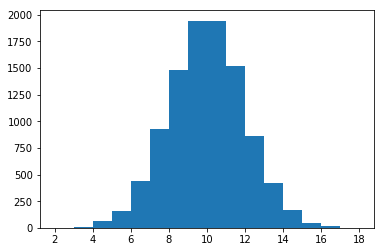

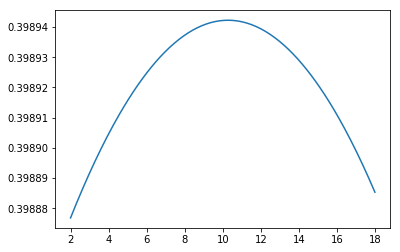

1.1896019893848846
0.9555688487086221
0.9238959073284461
0.9196094408358234


In [215]:
plt.hist(dataset, bins=np.linspace(2, 18, 17))
plt.show()

x = np.linspace(2, 18, 201)
y = model.likelihood(x)
plt.plot(x, y)
plt.show()

params = np.array([10., 1.])
print(-1. * np.mean(np.log(model.likelihood(dataset, params))))
params = np.array([10., 2.])
print(-1. * np.mean(np.log(model.likelihood(dataset, params))))
params = np.array([10., 3.])
print(-1. * np.mean(np.log(model.likelihood(dataset, params))))
params = np.array([10., 4.])
print(-1. * np.mean(np.log(model.likelihood(dataset, params))))

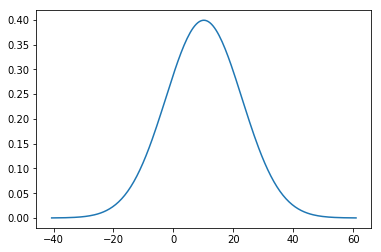

In [117]:
x = np.linspace(-4, 4, 201)
y = stats.norm.pdf(x)
x = model.forward_pass(x)
plt.plot(x, y)
plt.show()

In [2]:
'''def generate_dataset (n_data) :
    AB_mean = np.array([20, 50]).transpose()
    A = np.random.normal(0, 5, n_data)
    B = np.random.normal(0, 10, n_data)
    AB = []
    theta = np.pi/6
    rotation = np.array([[np.cos(theta), np.sin(theta)], [-1.*np.sin(theta), np.cos(theta)]])
    for Ap, Bp in zip(A, B) :
        AB.append(AB_mean + np.matmul(rotation, np.array([Ap, Bp])))
    AB = np.array(AB)
    return(AB)
        '''

'def generate_dataset (n_data) :\n    AB_mean = np.array([20, 50]).transpose()\n    A = np.random.normal(0, 5, n_data)\n    B = np.random.normal(0, 10, n_data)\n    AB = []\n    theta = np.pi/6\n    rotation = np.array([[np.cos(theta), np.sin(theta)], [-1.*np.sin(theta), np.cos(theta)]])\n    for Ap, Bp in zip(A, B) :\n        AB.append(AB_mean + np.matmul(rotation, np.array([Ap, Bp])))\n    AB = np.array(AB)\n    return(AB)\n        '

In [3]:
'''dataset = generate_dataset (10000)
print(dataset.shape)'''

'dataset = generate_dataset (10000)\nprint(dataset.shape)'

In [4]:
'''plt.hist2d(dataset[:,0], dataset[:,1])
plt.contour
plt.show()'''

'plt.hist2d(dataset[:,0], dataset[:,1])\nplt.contour\nplt.show()'

In [5]:
'''model = create_density_estimator( num_observables = 2    ,
                                  sigmoid         = True ,
                                  layers          = (20, 20))

dataset_Y = np.ones(shape=(len(dataset),))

model.fit(dataset,
          dataset_Y,
          validation_split=0.3,
          epochs=100000,
          callbacks=[EarlyStopping(patience=20, monitor="val_loss")])'''

'model = create_density_estimator( num_observables = 2    ,\n                                  sigmoid         = True ,\n                                  layers          = (20, 20))\n\ndataset_Y = np.ones(shape=(len(dataset),))\n\nmodel.fit(dataset,\n          dataset_Y,\n          validation_split=0.3,\n          epochs=100000,\n          callbacks=[EarlyStopping(patience=20, monitor="val_loss")])'

In [6]:
'''X = np.linspace(np.min(dataset[:,0]), np.max(dataset[:,0]), 5)
Y = np.linspace(np.min(dataset[:,1]), np.max(dataset[:,1]), 5)
X, Y = np.meshgrid(X, Y)
Z = np.zeros(shape = X.shape)
for i in range(5) :
    for j in range(5) :
        x = X[i, j]
        y = Y[i, j]
        Z[i, j] = model.predict(np.array([[x, y]]))[0]
print(Z)'''

'X = np.linspace(np.min(dataset[:,0]), np.max(dataset[:,0]), 5)\nY = np.linspace(np.min(dataset[:,1]), np.max(dataset[:,1]), 5)\nX, Y = np.meshgrid(X, Y)\nZ = np.zeros(shape = X.shape)\nfor i in range(5) :\n    for j in range(5) :\n        x = X[i, j]\n        y = Y[i, j]\n        Z[i, j] = model.predict(np.array([[x, y]]))[0]\nprint(Z)'